# Refinement Supervision Testing

#### Overview
In the LoFTR (Local Feature Transformer) framework, the refinement of coarse matches is a crucial second step. This refinement process involves determining the specific pixel in crop_2 that aligns with the central pixel of a given patch in crop_1. Notably, this alignment is assessed within a 16x16 patch in the fine feature space. To enhance neural network compatibility, we utilize relative coordinates centered around the midpoint of each patch.

#### Testing Strategy
To verify the accuracy and efficacy of our dataset implementation within the LoFTR framework, we propose the following testing methodology:

1. Recreate the pixel mapping process from Mid pixels in patches of crop_1 to their corresponding pixels in crop_2, leveraging only the match_matrix and relative_coordinates. These are the two key variables accessible during the test phase. Considering that each fine feature symbolizes a 4x4 pixel area in the original crop, the remapped pixels should ideally align within a 4-pixel accuracy range.
2. Evaluate the validity of the L2 loss as implemented in the original LoFTR model, specifically checking whether it accurately returns a value of 0 for perfect predictions and behaves as expected under various conditions.

In [1]:
import sys
sys.path.append('c:\\Users\\robin\\Documents\\HyperBrain')
sys.path.append('c:\\Users\\robin\\Documents\\HyperBrain\\source')

In [2]:
import torch
from source.datasets.brain_dataset import BrainDataset
from source.visualization.image_visualization import plot_images_with_matches_via_mapping

In [3]:
images_directory = 'C:\\Users\\robin\\Documents\\HyperBrain\\data\\cyto_downscaled_3344_3904'
train = False
dataset = BrainDataset(images_directory=images_directory, train=train)

In [4]:
image_1_crop, image_2_crop, match_matrix, relative_positions, crop_coordinate_mapping = dataset[0]

image_2_crop.shape: torch.Size([1, 640, 640]), image_2_transformed.shape: torch.Size([1, 3344, 3904]), image_1.shape: torch.Size([1, 3344, 3904])


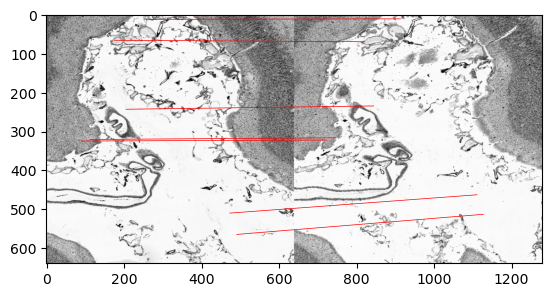

In [8]:
plot_images_with_matches_via_mapping(image_1=image_1_crop, image_2=image_2_crop, coordinate_mapping=crop_coordinate_mapping, number_of_matches=10, sample_keypoints_randomly=True)

#### Reproduce mid_pixel mappings of crop_coordinate_mapping using match_matrix and relative_coordinates

In [9]:
# Get matched patches in crop 1 and crop 2
crop_1_patch_indices = match_matrix.nonzero()[:, 0]  # Get all patch indices in crop 1
crop_2_patch_indices = match_matrix.nonzero()[:, 1]  # Get all patch indices in crop 2

In [11]:
from source.data_processing.patch_processing import get_patch_coordinates
# Get mid point of patches in crop 1 and crop 2
crop_1_patch_mid_indices = (
    get_patch_coordinates(patch_indices=crop_1_patch_indices)
    + torch.Tensor([8, 8]).long()
)  # Get all patch coordinates in crop 1 and add 8 to get the mid point of the patch
crop_2_patch_mid_indices = (
    get_patch_coordinates(patch_indices=crop_2_patch_indices)
    + torch.Tensor([8, 8]).long()
)  # Get all patch coordinates in crop 2 and add 8 to get the mid point of the patch